# Files d'attente - Projet Slicing
# Arnaud Capitan & Maëliss De Beaumont

___

Dans ce rendu, l'objectif est de trouver un moyen de mettre en place à la fois le haut débit mobile améliore (eMBB) qui ne nécessite pas de priorité particulière, et les communications ultra fiables à faible latence (URLLC) qui doivent présenter très peu de perte et doit être prioritaire, au sein d'une même file d'attente.

#### $\underline{\text{Ce qu'il faut faire :}}$

1] Dans un premier temps, nous étudions un modèle théorique qui met en place ce système.

2] Dans un deuxième temps, nous étudions un modèle plus réaliste à mettre en place mais dont l'étude est plus complexe.
___

In [150]:
import numpy as np
import matplotlib.pyplot as plt

#### Note avant de commencer :

Tout au long de ce compte-rendu, pour la génération de toutes nos variables aléatoires, nous ne nous servirons que de $\textit{np.random.uniform(0,1)}$ comme il était indiqué dans le cours. Nous nous créons donc nos propres générateurs de variables aléatoires selon les besoins.

___

### Partie 1 : Préliminaires

1) Écrire une fonction Python qui renvoie le nombre moyen de clients dans une file M/M/S/S à l’état stationnaire sans calculer de factorielle


Une file M/M/S/S, dans la nomenclature de Kendall, signifie que l'on a :

 - Un processus d'arrivée sans mémoire, donc de loi exponentielle de (paramètre $\lambda$)
 - Un processus de temps de service sans mémoire, donc de loi exponentielle (de paramètre $\mu$)
 - S serveurs
 - S serveurs + places dans la file d'attente, donc pas de file d'attente
 - La discipline de service n'est pas indiquée, elle est donc pas défaut FIFO (First In First Out)

Cette question revient à calculer l'espérance à l'état stationnaire de notre nombre de clients servis (puisqu'il n'y a pas de file d'attente / buffer), ce qui revient à calculer l'espérance du nombre de serveurs occupés. On dispose des probabilités que S serveurs soient occupés à l'état stationnaire :

$\text{Erl}_{\text{B}}[\rho,S] = \dfrac{\dfrac{\rho ^S}{S!}}{\sum _{j=0}^S \dfrac{\rho ^j}{j!}}$

Ainsi que la relation de récurrence de la formule d'Erlang-B :

$\text{Erl}_{\text{B}}[\rho,0] = 1$

$\dfrac{1}{\text{Erl}_{\text{B}}[\rho,S+1]} = 1 + \dfrac{S+1}{\rho \text{Erl}_{\text{B}}[\rho,S]}$

ou aussi :

$\dfrac{1}{\text{Erl}_{\text{B}}[\rho,S]} = 1 + \dfrac{S}{\rho \text{Erl}_{\text{B}}[\rho,S-1]}$

En notant m le nombre de client moyen dans la file (donc entrain d'être servis) à l'état stationnaire, on a :

$m = \mathbb{E}[\text{Nombre de serveurs en service}]$

$m = \sum _{k=0} ^S k \mathbb{P}(\text{Nombre de serveurs en service} = k)$

Cette dernière probabilité est donnée par $\text{Erl}_{\text{B}}[\rho,k]$, donc :

$m = \sum _{k=0} ^S k \dfrac{\dfrac{\rho ^k}{k!}}{\sum _{j=0}^S \dfrac{\rho ^j}{j!}}$

On simplifie l'expression :

$m = \sum _{k=1} ^S \rho \dfrac{\dfrac{\rho ^{(k-1)}}{(k-1)!}}{\sum _{j=0}^S \dfrac{\rho ^j}{j!}}$

$ m = \rho (1 - \dfrac{\dfrac{\rho ^S}{S!}}{\sum _{j=0}^S \dfrac{\rho ^j}{j!}}) $

$ m = \rho (1 - \text{Erl}_{\text{B}}[\rho,S]) $

Nous utiliserons la relation de récurrence pour calculer m, car il est demandé de calculer cette valeur sans calculer de factorielle.

$\dfrac{1}{\text{Erl}_{\text{B}}[\rho,k+1]} = \dfrac{\rho \text{Erl}_{\text{B}}[\rho,k] + k+1}{\rho \text{Erl}_{\text{B}}[\rho,k]}$

$\text{Erl}_{\text{B}}[\rho,k+1] = \dfrac{\rho \text{Erl}_{\text{B}}[\rho,k]}{\rho \text{Erl}_{\text{B}}[\rho,k] + k+1}$

In [151]:
def mean_number_waiting_customers(arrival_rate,service_rate,nb_of_servers):
    Erl = 1 #Valeur de ErlangB[rho,0], initialisation de la récurrence
    L_Erl = []
    rho = arrival_rate/service_rate #lambda/mu
    for k in range(1,nb_of_servers+1): # k de 0 à S inclus
        Erl = rho*Erl/(rho*Erl+k) #Relation de récurrence
        L_Erl.append(Erl)
    m = rho*(1-L_Erl[-1])
    return(m,L_Erl)

2) Pour des paramètres $\rho$ et $S$ tels que $\text{Erl}_{\text{B}}[\rho,S]$ soit petit (de l’ordre de $10^{-3}$ ), qu’est-ce que l’on remarque à propos du nombre moyen de clients ?

Expliquer ce phénomène en vous aidant des résultats connus sur la $M/M/\infty$.


In [152]:
lambda_param = 4
mu_param = 5
rho = lambda_param/mu_param
S = 5

m, L_Erl = mean_number_waiting_customers(lambda_param,mu_param,S)

print(f"ErlB[rho,S] = {L_Erl[-1]:.5f}")
print(f"Nombre moyen de clients pour rho = {rho}, S = {S} : {m:.5f}")

ErlB[rho,S] = 0.00123
Nombre moyen de clients pour rho = 0.8, S = 5 : 0.79902


On remarque que la valeur du nombre de client moyen, lorsque que $\text{Erl}_{\text{B}}[\rho,S]$ est de l’ordre de $10^{-3}$, que le nombre de clients moyen approche la valeur :

$$\rho = \dfrac{\lambda}{\mu} = \dfrac{\text{Arrival rate}}{\text{Service rate}}$$

On peut le montrer par un graphe, en gardant $\rho$ constant :

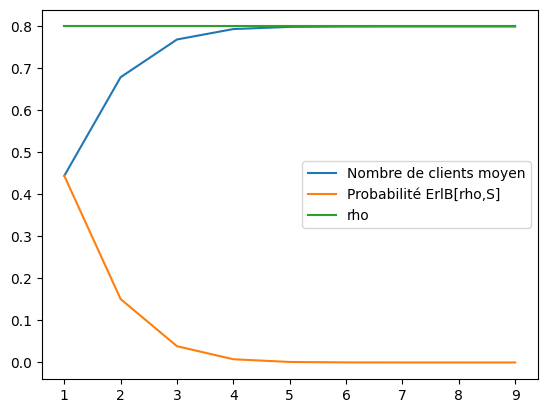

In [153]:
L_m = []
L_Erl = []
for S in range(1,10):
    m, Erl = mean_number_waiting_customers(lambda_param,mu_param,S)
    L_m.append(m)
    L_Erl.append(Erl[-1])

plt.plot([S for S in range (1,10)],L_m,label = 'Nombre de clients moyen')
plt.plot([S for S in range (1,10)],L_Erl,label = 'Probabilité ErlB[rho,S]')
plt.plot([S for S in range (1,10)],[rho*(1-L_Erl[-1]) for S in range (1,10)], label = 'rho')
plt.legend()
plt.show()

En effet, dans une file M/M/$\infty$, le nombre de serveurs occupés en moyenne est égal au taux $\rho$, qui vaut le taux d'arrivée divisé par le temps de service.

___

### Partie 2 : Modélisation

On considère un systèle analytiquement facile mais difficilement implémentable dans le cas réel.

### Modèle considéré

On considère une file d’attente avec un buffer infini et $S$ serveurs. Il y a deux classes de clients de type 1 et de type 2. 

 - Les clients de type 1 ont une priorité plus élevée que les clients de type 2. 
 - Les clients de type 1 arrivent selon un processus de Poisson de paramètre $\lambda _1$ et les clients de type 2 arrivent selon un processus de Poisson de paramètre $\lambda _2$. 
 - Les clients de type 1 ont une durée de service exponentielle de paramètre
$\mu _1$ et les clients de type 2 ont une durée de service exponentielle de paramètre $\mu _2$.
 - Les clients de type 1 ne peuvent pas être bufferisés et doivent être servis immédiatement. Les clients de type 2 peuvent être bufferisés. 
 - On suppose que la capacité de la file d’attente est infinie.

Les clients de classe 1 préemptent les serveurs : s’il reste des serveurs libres, ils s’y mettent normalement mais si tous les serveurs sont pris, ils prennent la place d’un client de classe 2. Celui-ci se retrouve dans le buffer et reprendra son service, là où il en était, dès qu’un serveur se libérera. S’il n’y a que des clients de classe 1 en service, le client de type 1 qui arrive est perdu.

Les clients de classe 2 ne peuvent accéder à un serveur que s’il y en a de libre. S’ils arrivent et qu’il n’y a pas de serveur libre, ils sont mis dans le buffer.

On note $Q_1$ le nombre de clients de type 1 dans le système et $Q_2$ le nombre de clients de type 2 dans le système. On note $S_1$ le nombre de serveurs occupés par des clients de type 1 et $S_2$ le nombre de serveurs occupés par des clients de type 2. On note $B$ le nombre de clients de type 2 dans le buffer.

___

1) Quelles sont les contraintes sur les variables d’état du système et comment les variables $Q_2$, $S_2$ et $B$ sont-elles reliées ? Expliquer en particulier
pourquoi : 

$$Q_1 + S_2 < S$$ 

Ne peut se produire que si $B = 0$

2) Montrer que le processus $Q_1$ est un processus de Markov et reconnaître sa dynamique comme celle d’une file simple dont on précisera les caractéristiques.

3) Écrire les transitions possibles du processus de Markov $(Q_1, Q_2)$. Montrer en particulier que le taux de transition de l’état $(Q_1, Q_2)$ à l’état $(Q_1, Q_2 − 1)$ est donnée par:

$$ min(Q_2, S − Q_1) \mu _2 $$

4) Simuler l’évolution de ce système en Python. On prendra comme valeurs :

$S = 10, \mu _1 = 2, \mu _2 = 1, \lambda _1 = 4, \lambda _2 = 3$

On note $(x_1, x_2)$ le processus ainsi construit. On vérifiera notamment que :

$$\dfrac{1}{T} \int _0 ^T \mathbb{1}_{(S)}(x_1(s))ds \overset{T\to+\infty}{\longrightarrow} \dfrac{\dfrac{\rho ^S}{S!}}{\sum _{j=0}^S \dfrac{\rho ^j}{j!}}$$

Préalablement, on justifiera cette identité.
___

### Réponses :

1. Contraintes et relations des variables d'état

On a $Q_2 = S_2 + B$

Le nombre de clients de classe 2 dans le système est égal au nombre de clients de classe 2 dans le buffer (de taille infini) plus le nombre de clients entrain d'occuper des serveurs (ou réciproquement le nombre de serveurs occupés par des clients de classe 2).

On a que $S_1 = S \iff Q_2 = B$, si tous les serveurs sont occupés par des clients de classe 1, alors tous les clients de classe 2 présents dans le système sont dans le buffer en attente d'un serveur.

On a aussi $S_1 + S_2 \leq S$

On a de plus $Q_1 = S_1$, car si un client de classe 1 n'est pas servi, alors il est perdu.

Toutes les variables sont positives.

$Q_1 + S_2 < S$ peut se réécrire avec l'égalité ci-dessus :

$Q_1 + S_2 < S \iff S_1 + S_2 < S \iff$ Des serveurs restent disponibles, et tous les clients de classe 1 et de classe 2 sont servis $\iff$ Il n'y a personne dans le buffer, donc $B = 0$

___

2. $Q_1$ processus de Markov

Montrons que le processus $Q_1$ est un processus de Markov. 

Le processus $Q_1$ prend la priorité sur tous les clients de classe 2, il se comporte donc comme si ces clients n'existaient pas. Les clients de classe 1 n'ont pas de buffer, ils disparaissent si tous les $S$ serveurs sont occupés. On en déduit que le processus $Q_1$ se comporte comme une file M/M/S/S, avec pour paramètre le taux d'arrivée $\lambda _1$ et pour temps de service $\mu _1$, tous deux suivants des lois exponentielles, car les instants d'arrivée d'une loi de Poisson de paramètre $\lambda _1$ suivent une loi exponentielle de paramètre $\lambda _1$ d'après le cours (d'où le M de Memory Less).

On en déduit ainsi que l'évolution processus $Q_1$ ne dépend que de son dernier état : c'est donc un processus de Markov. Il ne peut qu'augmenter ou diminuer de 1.

##### Réponse résumée : Le processus $Q_1$ se comporte comme une file M/M/S/S, de paramètres $\lambda _1$ et $\mu _1$ respectivement pour les taux d'arrivée et de temps de service

___

3. Transitions du processus de Markov $(Q_1,Q_2)$

Transitions possibles depuis $(Q_1,Q_2)$ :

 - $(Q_1+1,Q_2)$ avec pour taux $\lambda _1$ pour $0 \leq Q_1 \leq S-1$, $Q_2 \geq 0$
 - $(Q_1-1,Q_2)$ avec pour taux $Q_1 \mu _1$ pour $1 \leq Q_1 \leq S$, $Q_2 \geq 0$

Ces deux premières transitions s'écrivent facilement en appliquant l'égalité $Q_1 = S_1$.

Pour la transition suivante, peu importe si le client de classe 2 arrivant est servi ou non, il rentre dans le système dans tous les cas.

 - $(Q_1,Q_2+1)$ avec pour taux $\lambda _2$ pour $0 \leq Q_1 \leq S$, $Q_2 \geq 0$
 - $(Q_1,Q_2-1)$ avec pour taux $S_2 \mu _2$ pour $0 \leq Q_1 \leq S$, $Q_2 \geq 0$

Or, $S_2 = \begin{cases}
S - Q_1 & \text{si B > 0} \\
Q_2 & \text{si B = 0}
\end{cases}$

Donc le taux de transition est le minimum des deux valeurs, soit :

 - $(Q_1,Q_2-1)$ avec pour taux $min(S-Q_1,Q_2) \mu _2$ pour $0 \leq Q_1 \leq S$, $Q_2 \geq 0$

___

4. Simulation du système en Python et identité

On souhaite justifier l'identité :

$$\dfrac{1}{T} \int _0 ^T \mathbb{1}_{(S)}(x_1(s))ds \overset{T\to+\infty}{\longrightarrow} \dfrac{\dfrac{\rho ^S}{S!}}{\sum _{j=0}^S \dfrac{\rho ^j}{j!}}$$

##### Un théorème du cours nous dit que pour X un processus de Markov de générateur infinitésimal Q, X irréductible, on a équivalence entre :

- Tous les états de notre processus sont récurrents positifs 
- $\exists ! (\pi (x), x \in E)$ avec :
  - $\pi (x) > 0$, $\forall x \in E$
  - $\sum _{x \in E} \pi (x) = 1$
  - $\pi Q = 0$

Et dans ce cas-là :

$$\dfrac{1}{T} \int _0 ^T \mathbb{1}_{(S)}(x_1(s))ds \overset{T\to+\infty}{\longrightarrow} \pi(S)$$

___

Ici, on a montré que notre processus $(x_1)$ (qui correspond au processus $Q_1$) est un processus de Markov, qui est irréductible puisque tous les états communiquent.
Son générateur infinitésimal est donné par Q :

$$
\begin{bmatrix}
-\lambda_1 & \lambda_1 & 0 & \cdots & 0 \\
\mu_1 & -(\mu_1 + \lambda_1) & \lambda_1 & \ddots & \vdots \\
0 & 2 \mu_1 & -(2\mu_1 + \lambda_1) & \ddots  \\
\vdots & \ddots & \ddots & \ddots & \lambda_1\\
0 & \cdots & 0 & S \mu_1 & -S \mu_1 \\ 
\end{bmatrix}
$$

En posant $\rho = \dfrac{\lambda}{\mu}$, l'égalité $\pi Q = 0$ nous donne :

$\pi(i+1) = \dfrac{\rho}{i+1}\pi(i)$, $\forall i \in [|1,N|]$

Donc $\pi(i) = \dfrac{\rho ^i}{i!} \pi (0)$

La condition de normalisation nous donne :

$\sum _{i=0}^S \pi (i) = 1 \iff \sum _{i=0}^S \dfrac{\rho ^i}{i!} \pi (0) = 1 \iff \pi (0) = \dfrac{1}{\sum _{i=0}^S \dfrac{\rho ^i}{i!}}$

Ainsi, $\pi(i) = \dfrac{\dfrac{\rho ^i}{i!}}{\sum _{i=0}^S \dfrac{\rho ^i}{i!}}$, on retombe bien sur la formule d'Erlang-B donnée par le cours pour la file M/M/S/S. 

Toutes les conditions de notre théorème sont remplies, on en déduit que l'identité est vérifiée, et que l'on a bien :

$$\dfrac{1}{T} \int _0 ^T \mathbb{1}_{(S)}(x_1(s))ds \overset{T\to+\infty}{\longrightarrow} \pi(S) = \dfrac{\dfrac{\rho ^S}{S!}}{\sum _{j=0}^S \dfrac{\rho ^j}{j!}}$$

___


On rappelle par le cours que les instants $T_n$ d'un processus de Poisson d'intensité $\lambda _1$ sont modélisés à l'aide de lois exponentielles $\xi _n \sim \text{Exp} (\lambda _1)$ i.i.d. avec :

$T_0 = 0$

$T_n = \sum _{k=1} ^n \xi _k $ pour $n \geq 1$

On peut de plus simuler une loi exponentielle $\xi$ à l'aide d'une loi uniforme.

En effet, pour :

$ U \sim  \mathcal{U}([0,1]) $ 

$ V = -\frac{1}{\lambda _1}\ln (U) $

Alors $V \sim  \text{Exp} (\lambda _1)$

In [154]:
def loi_exponentielle(param):
    U = np.random.uniform(0,1)
    return(-np.log(U)/param)

___

Nous allons faire les calculs du prochain temps "d'événement" dans le cas où l'on se trouve dans le milieu de notre processus de Markov. Aux extrémités les calculs sont plus simples (moins de transitions possibles), et sont très similaires à ceux présentés.

Dans le cadre de notre simulation, le prochain temps "d'événement" à l'étape n est obtenu par :

$T_{n+1} \sim min(\text{Exp}(\lambda _1),\text{Exp}(\lambda _2),\text{Exp}(\mu _1), \text{Exp}(\mu _2))$

D'après le cours, on a :

$ min(\text{Exp}(\lambda _1),\text{Exp}(\lambda _2),\text{Exp}(\mu _1),\text{Exp}(\mu _2)) \sim \text{Exp}(\lambda _1 + \lambda _2 + \mu _1 + \mu _2)$

Donc :

$T_{n+1} \sim \text{Exp}(\lambda _1 + \lambda _2 + \mu _1 + \mu _2)$

___

On en profite pour montrer le résultat indiqué dans le cours pour deux variables exponentielles (le résultat s'étend après facilement à n variables exponentielles):

Soit $X \sim \text{Exp}(\beta)$, $Y \sim \text{Exp}(\gamma)$, $X \perp\!\!\!\perp Y$, $U = min(X,Y)$

$\forall t \geq 0$

$\mathbb{P}(U \leq t) = \mathbb{P}(min(X,Y) \leq t) = 1 - \mathbb{P}(min(X,Y) > t)$

Cette dernière condition ne se réalise que si à la fois X et Y sont supérieures à t. On en déduit que :

$\mathbb{P}(U \leq t) = 1 - \mathbb{P}(X > t, Y > t)$

Par indépendance :

$\mathbb{P}(U \leq t) = 1 - \mathbb{P}(X > t)\mathbb{P}(Y > t)$

$\mathbb{P}(U \leq t) = 1 - e^{\beta t}e^{\gamma t} = 1 - e^{(\beta + \gamma) t}$

Ce qui nous donne le résultat, car pour une loi exponentielle V de paramètre $\lambda$, on a :

$\mathbb{P}(V \leq t) = \int _0^t \lambda e^{-\lambda x} dx = 1 - e^{-\lambda t}$

___

Nous allons créer une fonction permettant de générer les prochains instants d'événement (arrivée) en fonction des différents paramètres.

Nous allons aussi créer une fonciton qui s'occupera de gérer les transitions de notre chaîne de Markov.

In [155]:
def genere_instant(Q1,Q2,lambda1,lambda2,mu1,mu2,S):
    if Q1 == 0 and Q2 == 0:
        return(loi_exponentielle(lambda1+lambda2))
    elif Q1 == 0 :
        return(loi_exponentielle(lambda1+lambda2+min(Q2,S-Q1)))
    elif Q2 == 0 and Q1 == S:
        return(loi_exponentielle(lambda2+Q1*mu1))
    elif Q2 == 0 :
        return(loi_exponentielle(lambda1+lambda2+Q1*mu1))
    elif Q1 == S :
        return(loi_exponentielle(lambda2+Q1*mu1+min(Q2,S-Q1)*mu2))
    else :
        return(loi_exponentielle(lambda1+lambda2+Q1*mu1+min(Q2,S-Q1)*mu2))

def actualisation(Q1,Q2,lambda1,lambda2,mu1,mu2,S):
    U = np.random.uniform(0,1)
    if Q1 == 0 and Q2 == 0:
        if U <= lambda1/(lambda1+lambda2):
            return(Q1+1,Q2)
        else :
            return(Q1,Q2+1)
    elif Q1 == 0 :
        if U <= lambda1/(lambda1+lambda2+min(Q2,S-Q1)*mu2):
            return(Q1+1,Q2)
        elif lambda1/(lambda1+lambda2+min(Q2,S-Q1)*mu2) < U <= (lambda1+lambda2)/(lambda1+lambda2+min(Q2,S-Q1)*mu2):
            return(Q1,Q2+1)
        else :
            return(Q1,Q2-1) #L'un des clients de classe 2 est parti, et un des clients de classe 2 du buffer le remplace
    elif Q2 == 0 and Q1 == S:
        if U <= lambda2/(lambda2+Q1*mu1):
            return(Q1,Q2+1)
        else:
            return(Q1-1,Q2)
    elif Q2 == 0 :
        if U <= lambda1/(lambda1+lambda2+Q1*mu1):
            return(Q1+1,Q2)
        elif lambda1/(lambda1+lambda2+Q1*mu1) < U <= (lambda1+lambda2)/(lambda1+lambda2+Q1*mu1):
            return(Q1,Q2+1)
        else:
            return(Q1-1,Q2)
    if Q1 == S :
        if U <= lambda2/(lambda2+Q1*mu1+min(Q2,S-Q1)*mu2):
            return(Q1,Q2+1)
        elif lambda2/(lambda2+Q1*mu1+min(Q2,S-Q1)*mu2) < U <= (lambda2+Q1*mu1)/(lambda2+Q1*mu1+min(Q2,S-Q1)*mu2):
            return(Q1-1,Q2)
        else:
            return(Q1,Q2-1)
    else :
        if U <= lambda1/(lambda1+lambda2+Q1*mu1+min(Q2,S-Q1)*mu2):
            return(Q1+1,Q2)
        elif lambda1/(lambda1+lambda2+Q1*mu1+min(Q2,S-Q1)*mu2) < U <= (lambda1+lambda2)/(lambda1+lambda2+Q1*mu1+min(Q2,S-Q1)*mu2):
            return(Q1,Q2+1)
        elif (lambda1+lambda2)/(lambda1+lambda2+Q1*mu1+min(Q2,S-Q1)*mu2) < U <= (lambda1+lambda2+Q1*mu1)/(lambda1+lambda2+Q1*mu1+min(Q2,S-Q1)*mu2):
            return(Q1-1,Q2)
        else:
            return(Q1,Q2-1)

In [156]:
def simulation(lambda1,lambda2,mu1,mu2,S,T_max):
    proba = 0
    Q1 = 0
    Q2 = 0
    L_Q1 = [Q1]
    L_Q2 = [Q2]
    T = 0
    L_T = [T]
    while T < T_max:
        delta_T = genere_instant(Q1,Q2,lambda1,lambda2,mu1,mu2,S)
        T += delta_T
        L_T.append(T)
        Q1,Q2 = actualisation(Q1,Q2,lambda1,lambda2,mu1,mu2,S)
        L_Q1.append(Q1)
        L_Q2.append(Q2)
        if Q1 == S:
            proba +=1
    return(L_Q1,L_Q2,L_T,proba/len(L_Q1))        

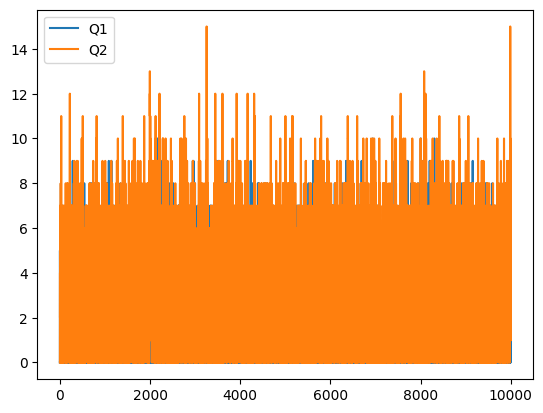

Proba obtenue par la simulation : 3.576921701183961e-05, proba théorique : 3.8190167941263515e-05


In [157]:
S = 10
mu1 = 2
mu2 = 1
lambda1 = 4
lambda2 = 3

Q1,Q2,T,proba = simulation(lambda1,lambda2,mu1,mu2,S,10000)
plt.plot(T,Q1,label='Q1')
plt.plot(T,Q2,label='Q2')
plt.legend()
plt.show()

print(f"Proba obtenue par la simulation : {proba}, proba théorique : {mean_number_waiting_customers(lambda1,mu1,S)[1][-1]}")

On obtient des valeurs assez proches, ce qui est satisfaisant. De manière générale, l'ordre de grandeur est bon même si les valeurs ont une grande variance.

On affiche la simulation pour une valeur de temps plus faible, afin de voir les évolutions plus facilement :

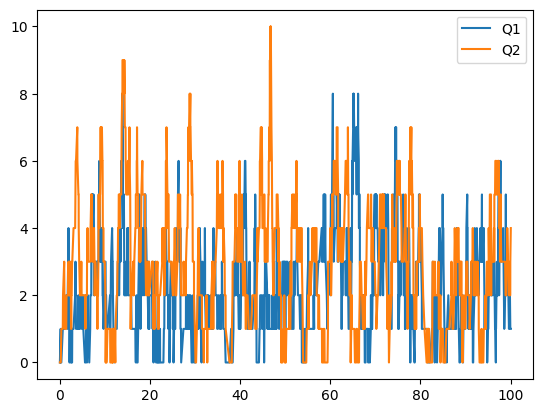

In [158]:
Q1,Q2,T,proba = simulation(lambda1,lambda2,mu1,mu2,S,100)
plt.plot(T,Q1,label='Q1')
plt.plot(T,Q2,label='Q2')
plt.legend()
plt.show()

___

### Partie 3 : Stationnarité

Il est montré dans [1] que ce système admet un régime stationnaire si et seulement si $\rho _2$ plus le nombre moyen de clients dans une file M/M/S/S de charge $\rho _1$ est strictement inférieur à $S$ :

$$ \rho _2 + \dfrac{\sum _{k=0}^S k\dfrac{\rho ^S}{S!}}{\sum _{j=0}^S \dfrac{\rho ^j}{j!}} < S$$

Avec $\rho _i = \dfrac{\lambda _i}{\mu _i}$
.
1. Illustrer ce résultat par simulation. Serait-il possible de  deviner (2) par simulation ?

Pour répondre à cette question, nous allons simuler 5 fois la simulation ci-dessus avec les paramètres vérifiant l'inégalité, et 5 fois la simulation avec des paramètres ne vérifiant pas l'inégalité.

Si les probabilités des 5 premières simulations convergent vers la probabilité stationnaire mais que celles des 5 dernières ne convergent pas, alors on aura non seulement montré le résultat par simulation, mais on pourra aussi dire que ce résultat peut se trouver par simulation car la borne est trouvable (difficilement devinable mais trouvable).

On commence par calculer $\rho _2 + m$, avec m défini dans la première partie, puis on choisit des valeurs différentes pour montrer le résultat.

On commence par les valeurs indiquées ci-dessus.

In [159]:
def conversion_proba(Q1):
    L = []
    for i in range(11):
        k = 0
        for elem in Q1:
            if elem == i:
                k+=1
        k/=len(Q1)
        L.append(k)
    return(L)

def simulation_stationnarite(lambda1,lambda2,mu1,mu2,S):
    for i in range(5):
        Q1,Q2,_,_ = simulation(lambda1,lambda2,mu1,mu2,S,1000)
        print(conversion_proba(Q1))

In [160]:
S = 10
mu1 = 2
mu2 = 1
lambda1 = 4
lambda2 = 3

rho2 = lambda2/mu2
m, _ = mean_number_waiting_customers(lambda1,mu1,S)

print(f"rho2 + m = {rho2+m}")

simulation_stationnarite(lambda1,lambda2,mu1,mu2,S)

rho2 + m = 4.999923619664117
[0.09667434494673194, 0.21724733659660236, 0.26641232363950473, 0.21170457817448893, 0.12611575007198386, 0.05391592283328534, 0.019723581917650446, 0.006262597178232076, 0.0016556291390728477, 0.00021595162683558884, 7.198387561186294e-05]
[0.10155574762316336, 0.23833189282627484, 0.26901469317199656, 0.20498415442235668, 0.11120714491501009, 0.04890521463555171, 0.01829443964275425, 0.005906078939786805, 0.0012244309997118986, 0.000432152117545376, 0.00014405070584845865]
[0.09387871041045306, 0.2297969038488851, 0.27204942479761396, 0.21083652890214458, 0.11447237608294276, 0.05191024002272405, 0.018676324385740663, 0.006391137622496805, 0.0016332907257491833, 0.00035506320124982244, 0.0]
[0.09739702517162471, 0.2382008009153318, 0.2801058352402746, 0.20223112128146453, 0.11119851258581236, 0.0464816933638444, 0.017663043478260868, 0.005434782608695652, 0.0011441647597254005, 0.00014302059496567506, 0.0]
[0.09929832022113544, 0.22673470834219292, 0.2670

On remarque que les probabilités sont stationnaires, elles sont globalement constantes (elles varient mais c'est attendu par la simulation).

In [161]:
S = 10
mu1 = 2
mu2 = 1
lambda1 = 15
lambda2 = 3

rho2 = lambda2/mu2
m, _ = mean_number_waiting_customers(lambda1,mu1,S)

print(f"rho2 + m = {rho2+m}")

simulation_stationnarite(lambda1,lambda2,mu1,mu2,S)

rho2 + m = 9.753422152077444
[0.0005454214896066905, 0.0045451790800557544, 0.01442336828071026, 0.03666444457911642, 0.07475304526998364, 0.12893157990424822, 0.1670504817889825, 0.1812920429064905, 0.17553481607175322, 0.1491424762135628, 0.06711714441548997]
[0.0003640224480509631, 0.0035795540725011375, 0.014591233126042772, 0.04070984377369938, 0.08327013499165782, 0.12846958895798574, 0.16820870620354922, 0.17979675413317153, 0.16563021386318824, 0.14612467768845747, 0.06925527074169574]
[0.0006962523460676878, 0.004177514076406127, 0.015711085548223043, 0.043288732820730154, 0.07692074831991282, 0.12293394684264697, 0.16658594175697766, 0.18117696918326573, 0.17036992189864988, 0.14745413816068292, 0.070684749046437]
[0.0005168901456413999, 0.0038614734409681047, 0.013834412721578643, 0.03569582535194138, 0.0715436772173067, 0.11730365775791297, 0.15923257016023595, 0.18276627443826204, 0.18395208124296877, 0.1575602785125726, 0.07373285901061145]
[0.0003324367614615129, 0.00332

Les probabilités, mêmes pour des paramètres qui donnent une valeur proche de S pour $\rho _2 + m$, restent stables, on a bien un modèle stationnaire.

In [162]:
S = 10
mu1 = 2
mu2 = 1
lambda1 = 15
lambda2 = 15

rho2 = lambda2/mu2
m, _ = mean_number_waiting_customers(lambda1,mu1,S)

print(f"rho2 + m = {rho2+m}")

simulation_stationnarite(lambda1,lambda2,mu1,mu2,S)

rho2 + m = 21.753422152077444
[0.0007317073170731707, 0.0047006651884700665, 0.017028824833702882, 0.042838137472283815, 0.08363636363636363, 0.12736141906873613, 0.1638580931263858, 0.17452328159645233, 0.16175166297117516, 0.14210643015521066, 0.08146341463414634]
[0.0009672030247076409, 0.0040666490811571265, 0.017321726897036843, 0.0421392772355579, 0.0798601951991559, 0.12384595093642839, 0.16020399191066562, 0.1757451859667634, 0.16928251121076232, 0.14824584542337113, 0.07832146311439374]
[0.0007701786814540973, 0.0050611741924126395, 0.017626089252706627, 0.04385617463251475, 0.08370742012146819, 0.12514303318369863, 0.16239767626089252, 0.175424698530059, 0.16662265645629787, 0.1431872194349089, 0.07620367925358683]
[0.000925456668796686, 0.0040323469140427035, 0.01674635876870194, 0.046383006852786283, 0.0852742216248375, 0.12608245378225327, 0.16008196901923627, 0.17724698675715575, 0.16711103276557301, 0.1403609281008307, 0.07575523874578587]
[0.0006771072232051198, 0.00428

En effet, le résultat obtenu n'est pas celui attendu : nous nous attendions à obtenir des résultats avec une variance trop grande pour indiquer une stationnarité des probabilités de Q1, mais finalement on l'obtient quand même.

##### Conclusion : Nous ne pouvons donc pas deviner ce résultat par simulation.

___

### Partie 4 : Calcul de la probabilité stationnaire

1) Montrer que la suite $(x_j)_{j \geq S}$ définie ci-dessous est solution des équations d’équilibre au delà du rang S.

$x_j = x_S R^{j−S} $ pour $j \geq S$

A partir de $j \geq S$, par multiplication avec le générateur infinitésimal, on a l'équation suivante, par stationnarité : 
$$x_{j-1} A_S + x_j B_S + \lambda_2 x_{j+1} I_d = 0$$
et on a $R$ la matrice telle que :
$$\lambda_2 I + RB_S + R^2 A_S = 0$$
on substitue $x_j = x_SR^{j-S} dans les équations d'équilibre pour $j \geq S$:
- pour $j=S$, on a bien $x_S = x_S$ est bien solution de l'état stationnaire ?????
- pour $j > S$ : on remplace dans les équations d'équilibre :
$$
\begin{align*}
x_S R^{j-1-S} A_S + x_S R^{j-S} B_S + \lambda_2 R^2 I &= x_S R^{j-1-S} (A_S + R B_S + \lambda_2 R^2 I) \\
&= x_S R^{j-1-S} \cdot 0 \\
&= 0
\end{align*}
$$
en reconnaissant l'égalité. Donc la suite est une solution à l'équilibre pour $j > S$. 

2) Établir que :

$x_{S−1} = −x_S (\tilde{B}_S + R \tilde{A}_S)$

On a d'après le générateur infinitésimal, et la relation $x_{S+1} = x_S R$ :
$ x_{S-1} \lambda_2 I + x_S B_S + x_{S+1} A_S = x_{S-1} \lambda_2 I + x_S B_S + x_S R A_S$

d'où, on a bien :
$$
\begin{align*}
x_{S-1} &= -x_S \frac{1}{\lambda_2} (B_S + R A_S) \\
x_{S-1} &= -x_S (\tilde{B_S} + R \tilde{A_S})
\end{align*}
$$

3) Expliciter par récurrence la suite de matrices $(T_j,j=S−1,··,0)$ telle que
l’on ait :

$$x_{j+1} = x_jT_j$$

A l'instant $S-1$, on a la relation précédente : $x_S = - x_{S-1}(\tilde{B_S} + R \tilde{A_S})^{-1}$ donc on a $T_{S-1} = (\tilde{B_S} + R \tilde{A_S})^{-1}$

On raisonne par récurrence descendante pour $0 \leq j \leq S-1$ avoir un tel $T_j$.

Dans le régime stationnaire, on a : 
$$
\begin{align*}
x_{j-1} \lambda_2 I + x_j B_j + x_{j+1} A_{j-1} &= x_{j-1} \lambda_2 I + x_j B_j + x_j T_j A_{j-1}\\
&= x_{j-1} \lambda_2 I + x_j (B_j + T_j A_{j-1}) \\
&= 0
\end{align*}
$$

On aura alors la relation suivante :
$$ x_j = - x_{j-1} \lambda_2 (B_j + T_j A_{j-1})^{-1}$$
et alors : $T_{j-1} = \lambda_2 (B_j + T_j A_{j-1})^{-1}$ la suite de matrices telles que pour $j = S-1, ..., 0$ on a $x_{j+1} = x_j T_j$, ce qui valide l'hypothèse de réccurence.

4. Montrer enfin que l’on a $x_0 ((M − \lambda _2 I) + T_0 A_1) = 0$ où $\tilde{M} = M/\lambda _2$

D'après la relation de récurence donnée par la Q3), on a $x_1 = x_0 T_0$ et d'après la relation à l'équilibre avec le générateur infinitésimal, on a :
$$x_0(M - \lambda_2 I) + x_1 A_1 = x_0(M - \lambda_2 I) + x_0 T_0 A_1 = 0$$
d'où on a bien : $x_0((M - \lambda_2 I) + T_0 A_1) =0$

### Partie 5 : Canaux de garde

On étudie un nouveau modèle qui permet de ne pas implémenter la politique préemptive (classe 1 qui prend la place de la classe 2 auprès des serveurs):

 - Les arrivées de classe 1 occupent un serveur tant qu’il y a un de libre et ne peuvent être mis dans la salle d’attente. 
 - En d’autres termes, si tous les serveurs sont pris, éventuellement en partie par des clients de classe 2, les clients de classe 1 qui arrivent sont perdus.
 - Les clients de classe 2 ne peuvent entrer dans les serveurs que s’il y a au moins G serveurs libres (avec G à déterminer mais généralement très petit devant S). Cette règle s’applique à leur arrivée ou au moment où un serveur se libère.


1) Pourquoi est-ce que le processus $(Q_1, Q_2)$ défini précédemment n’est plus un processus de Markov représentant ce système ?
2) Représenter la dynamique de ce système par un processus de Markov dont on
précisera le générateur infinitésimal.
3) Sans faire de calculs, est-ce que la condition de stabilité est plus ou moins contraignante sur $\rho _2$ que dans le premier modèle ?
___

1. Ce processus $(Q1,Q2)$ n'est plus un processus de Markov car les transitions ne dépendent plus seulement de l'état précédent. 

En effet, la caractéristique Markovienne se perd à cause de la règle qui s'applique pour les clients de classe 2 qui ne peuvent rentrer dans les serveurs que s'il y a au moins G serveurs libres à la fois à leur arrivée mais aussi au moment où un serveur se libère (les clients de classe 2 étant stockés dans le buffer précédemment).

Pour un client de classe 2 sortant du système, si d'autres clients de classe 2 sont en attente dans le buffer, alors à son départ, le client n'est pas immédiatement remplacé par un membre du buffer.

Contrairement au modèle précédent, il faut d'abord savoir combien il y a de membres de $Q_2$ en service, mais nous ne disposons pas de cette information avec seulement le couple de valeurs $(Q_1,Q_2)$ qui ne donne que le nombre de clients de classe 1 et de classe 2 présents dans le système.

##### Ce modèle n'est donc plus un processus de Markov.

2) Représentation de la dynamique de ce système par un processus de Markov et générateur infinitésimal.

Une représentation de Markov viable de ce processus serait de considérer à la fois $Q_1, Q_2$, et $S_2$ ou bien $S_1, S_2$, et $B$ (cela revient au même). On va plutôt partir sur ces deuxièmes écritures pour notre processus de Markov.

La matrice du générateur infinitésimal lié à ce processus est infini (à cause de la valeur $B$ du buffer qui peut être infinie) et peut s'écrire Q :

$$
\begin{bmatrix}
Q^{(0,0)} & Q^{(0,1)} & \cdots & Q^{(0,S)} \\
Q^{(1,0)} & Q^{(1,1)} & \cdots & Q^{(1,S)} \\
\vdots & \vdots & \ddots & \vdots  \\
Q^{(S,0)} & Q^{(S,1)} & \cdots & Q^{(S,S)} \\ 
\end{bmatrix}
$$

Chaque matrice infinie $Q^{(i,j)}$ peut se lire comme le générateur infinitésimal pour $i$ clients de classe 1 en service et $j$ clients de classe 2 en service.

Et on a pour chaque $Q^{(i,j)}$ :

La position dans la diagonale représente le nombre de clients de classe 2 dans le buffer. On a ainsi les transitions suivantes :

$$
\begin{bmatrix}
-\alpha & \alpha & 0 & 0 & \cdots \\
\beta & -(\beta + \alpha) & \alpha & 0 & \cdots \\
0 & \beta & -(\beta + \alpha) & \alpha & \vdots  \\
\vdots & \vdots & \ddots & \ddots & \vdots \\
\end{bmatrix}
$$

Avec $\alpha$ le coefficient des arrivées de clients de classe 2 dans la position $(S_1 = i, S_2 = j)$ qui se font servir (donc sous condition) et des clients des classe 1 qui se font servir.

On a donc $\alpha = \lambda _2 \mathbb{1}_{S-(i+j)>G} + \lambda _1 \mathbb{1}_{S-(i+j)>0}$

Pour ce qui est des départs, le taux change en fonction du nombre de clients dans le buffer, comme expliqué ci-dessus. On a donc $\beta$ le coefficient qui correspond au remplacement direct d'un client de classe 2 depuis le buffer directement dans la file. Cela se fait sous condition qu'au départ d'un client de classe 1 ou 2, il y a au moins G serveurs disponibles. On rappelle que le coefficient $\beta$ se trouve dans une diagonale donc le numéro commence par 1.

On a alors :

$\beta = (i\mu _1 + j\mu _2)\mathbb{1}_{S-(i+j)\geq G}$

Cette matrice fait bien apparaître les états de transition avec le buffer sur les diagonales des côtés.

3) Sans faire de calculs, est-ce que la condition de stabilité est plus ou moins contraignante sur $\rho _2$ que dans le premier modèle ?

On peut supposer que de la même façon où pour le premier modèle nous avions pour condition de stabilité :

$$ \rho _2 < S-m $$

On peut supposer que cette fois-ci, le nombre de serveurs devant être disponibles est d'au moins G, donc on devrait pouvoir écrire comme contrainte à minima :

$$ \rho _2 < min(S-m,S-G) $$

Ce qui est une contrainte plus contraignante que celle du premier modèle, mais cela est cohérent étant donné la règle supplémentaire sur les clients de classe 2.

___

# Fin du compte-rendu